In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
plt.rcParams.update({"figure.dpi": 300})

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score, mean_absolute_error, make_scorer

from xgboost import XGBRegressor #XGBClassifier  # or  for regression tasks
from sklearn.multioutput import MultiOutputRegressor

In [2]:
datafile = './data_v3.txt'
df = pd.read_csv(datafile, sep='\s+')
df.dropna(how='all', axis='columns', inplace=True)

In [3]:
df

,potential,Cu_loading,FE(glycerol),FE(n-proponal),FE(ethanol),FE(acetate),FE(acetone),FE(formate),j(total),ECSA,C_support,V_micro,V_meso,pore_area
0,-1.0,0.2,58.95348,0.80920,2.99785,3.53286,2.75771,8.03512,-2.857350,1288.3,micro,0.59,0.26,1511
1,-0.9,0.2,63.02599,0.00000,1.74447,3.47984,2.10915,7.78428,-1.517410,1288.3,micro,0.59,0.26,1511
2,-0.8,0.2,60.02130,0.00000,1.18207,4.48202,0.00000,4.14050,-0.915970,1288.3,micro,0.59,0.26,1511
3,-0.7,0.2,61.00858,0.00000,0.74646,2.69495,0.00000,0.00000,-0.578440,1288.3,micro,0.59,0.26,1511
4,-0.6,0.2,58.48887,0.00000,0.63929,2.48488,0.00000,0.00000,-0.350260,1288.3,micro,0.59,0.26,1511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,-0.7,6.4,17.61226,2.63206,19.72800,3.81659,0.00000,9.38566,-3.683698,1566.7,mix,0.34,0.56,1175
100,-0.6,6.4,14.71399,1.65843,14.59121,2.91781,0.00000,3.39485,-2.124498,1566.7,mix,0.34,0.56,1175
101,-0.5,6.4,9.57852,0.00000,9.07849,2.08148,0.00000,1.94378,-1.322136,1566.7,mix,0.34,0.56,1175
102,-0.4,6.4,6.24519,0.00000,3.45204,1.19281,0.00000,0.00000,-0.651209,1566.7,mix,0.34,0.56,1175


In [4]:
df.columns

Index(['potential', 'Cu_loading', 'FE(glycerol)', 'FE(n-proponal)',
       'FE(ethanol)', 'FE(acetate)', 'FE(acetone)', 'FE(formate)', 'j(total)',
       'ECSA', 'C_support', 'V_micro', 'V_meso', 'pore_area'],
      dtype='object')

# Selecting features

In [13]:
features = ['potential', 'Cu_loading',
            'V_micro', 'V_meso', 'pore_area'
]

targets = ['FE(glycerol)', 'FE(n-proponal)',
           'FE(ethanol)', 'FE(acetate)', 
           'FE(acetone)', 'FE(formate)'
          ]

X = df[features]
y = df[targets]

# Hyper-parameter tuning

In [27]:
# Hyper-parameter tuning

from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer

# Define the model
model = MultiOutputRegressor(
    XGBRegressor(
    n_jobs=1,  # Use a single thread for each model training to avoid oversubscription
    random_state=1
    )
)

# Define the parameter grid with the correct syntax for nested models
param_grid = {
    'estimator__n_estimators': [250, 500,],
    'estimator__max_depth': [5, 11],
    'estimator__learning_rate': [0.01, 0.125, 0.2],
    'estimator__subsample': [0.5, 1],
    'estimator__colsample_bytree': [0.4, 0.8],
    'estimator__gamma': [0, 1],
    'estimator__reg_alpha': [0, 1],
    'estimator__reg_lambda': [0, 1],
    'estimator__min_child_weight': [1,]
}


# Define the cross-validation strategy
cv = KFold(n_splits=3, shuffle=True, random_state=51)

# Define the scoring metric
scorer = make_scorer(r2_score) #, greater_is_better=False)


# Set up the Search - GridSearchCV or RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=model,

    # if using RandomizedSearchCV 
    param_distributions=param_grid,  # if using RandomizedSearchCV
    n_iter=500,  # Number of parameter settings that are sampled
    random_state=1,
    
    # if using GridSearchCV 
    #param_grid=param_grid, # when using GridSearchCV
    
    scoring=scorer,
    n_jobs=1, #-1,  # Use all available cores for parallel processing
    cv=cv,
    verbose=2,
    
)


search.fit(X, y)

# Best parameters
print("Best parameters found: ", search.best_params_)
print("Highest R2 found: ", search.best_score_)

c:\Users\fbhuiyan\Documents\ANL_projects\2_LDRD_DJ\Github_Repo\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 384 is smaller than n_iter=500. Running 384 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 384 candidates, totalling 1152 fits
[CV] END estimator__colsample_bytree=0.4, estimator__gamma=0, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_estimators=250, estimator__reg_alpha=0, estimator__reg_lambda=0, estimator__subsample=0.5; total time=   0.1s
[CV] END estimator__colsample_bytree=0.4, estimator__gamma=0, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_estimators=250, estimator__reg_alpha=0, estimator__reg_lambda=0, estimator__subsample=0.5; total time=   0.1s
[CV] END estimator__colsample_bytree=0.4, estimator__gamma=0, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_estimators=250, estimator__reg_alpha=0, estimator__reg_lambda=0, estimator__subsample=0.5; total time=   0.1s
[CV] END estimator__colsample_bytree=0.4, estimator__gamma=0, estimator__learning_rate=0.01, estimator__max_depth=5, estima

In [28]:
# Best parameters
print("Best parameters found: ", search.best_params_)
print("Highest R2 found: ", search.best_score_)

Best parameters found:  {'estimator__subsample': 0.5, 'estimator__reg_lambda': 1, 'estimator__reg_alpha': 1, 'estimator__n_estimators': 250, 'estimator__min_child_weight': 1, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.2, 'estimator__gamma': 0, 'estimator__colsample_bytree': 0.8}
Highest R2 found:  0.8686996698379517


## Cross-validation test

In [36]:
model = MultiOutputRegressor(
    XGBRegressor(
    n_estimators = 250,
    max_depth = 5,
    min_child_weight = 1,
    learning_rate = 0.2,
    subsample = 0.5,
    reg_lambda = 1, 
    reg_alpha = 1,
    gamma = 0,
    colsample_bytree = 0.8,
    n_jobs=1,  # Use a single thread for each model training to avoid oversubscription
    random_state=1
    )
)

# Cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=51)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))   # default scorer for xgbregressor is R2 score

print(scores)
print("R2 score:", round(np.mean(scores),3), round(np.std(scores),3))

[0.9092671871185303, 0.8742333054542542, 0.8407473564147949, 0.7727961540222168, 0.8396732211112976]
R2 score: 0.847 0.045


## Learning curve

Text(0, 0.5, 'R² Score')

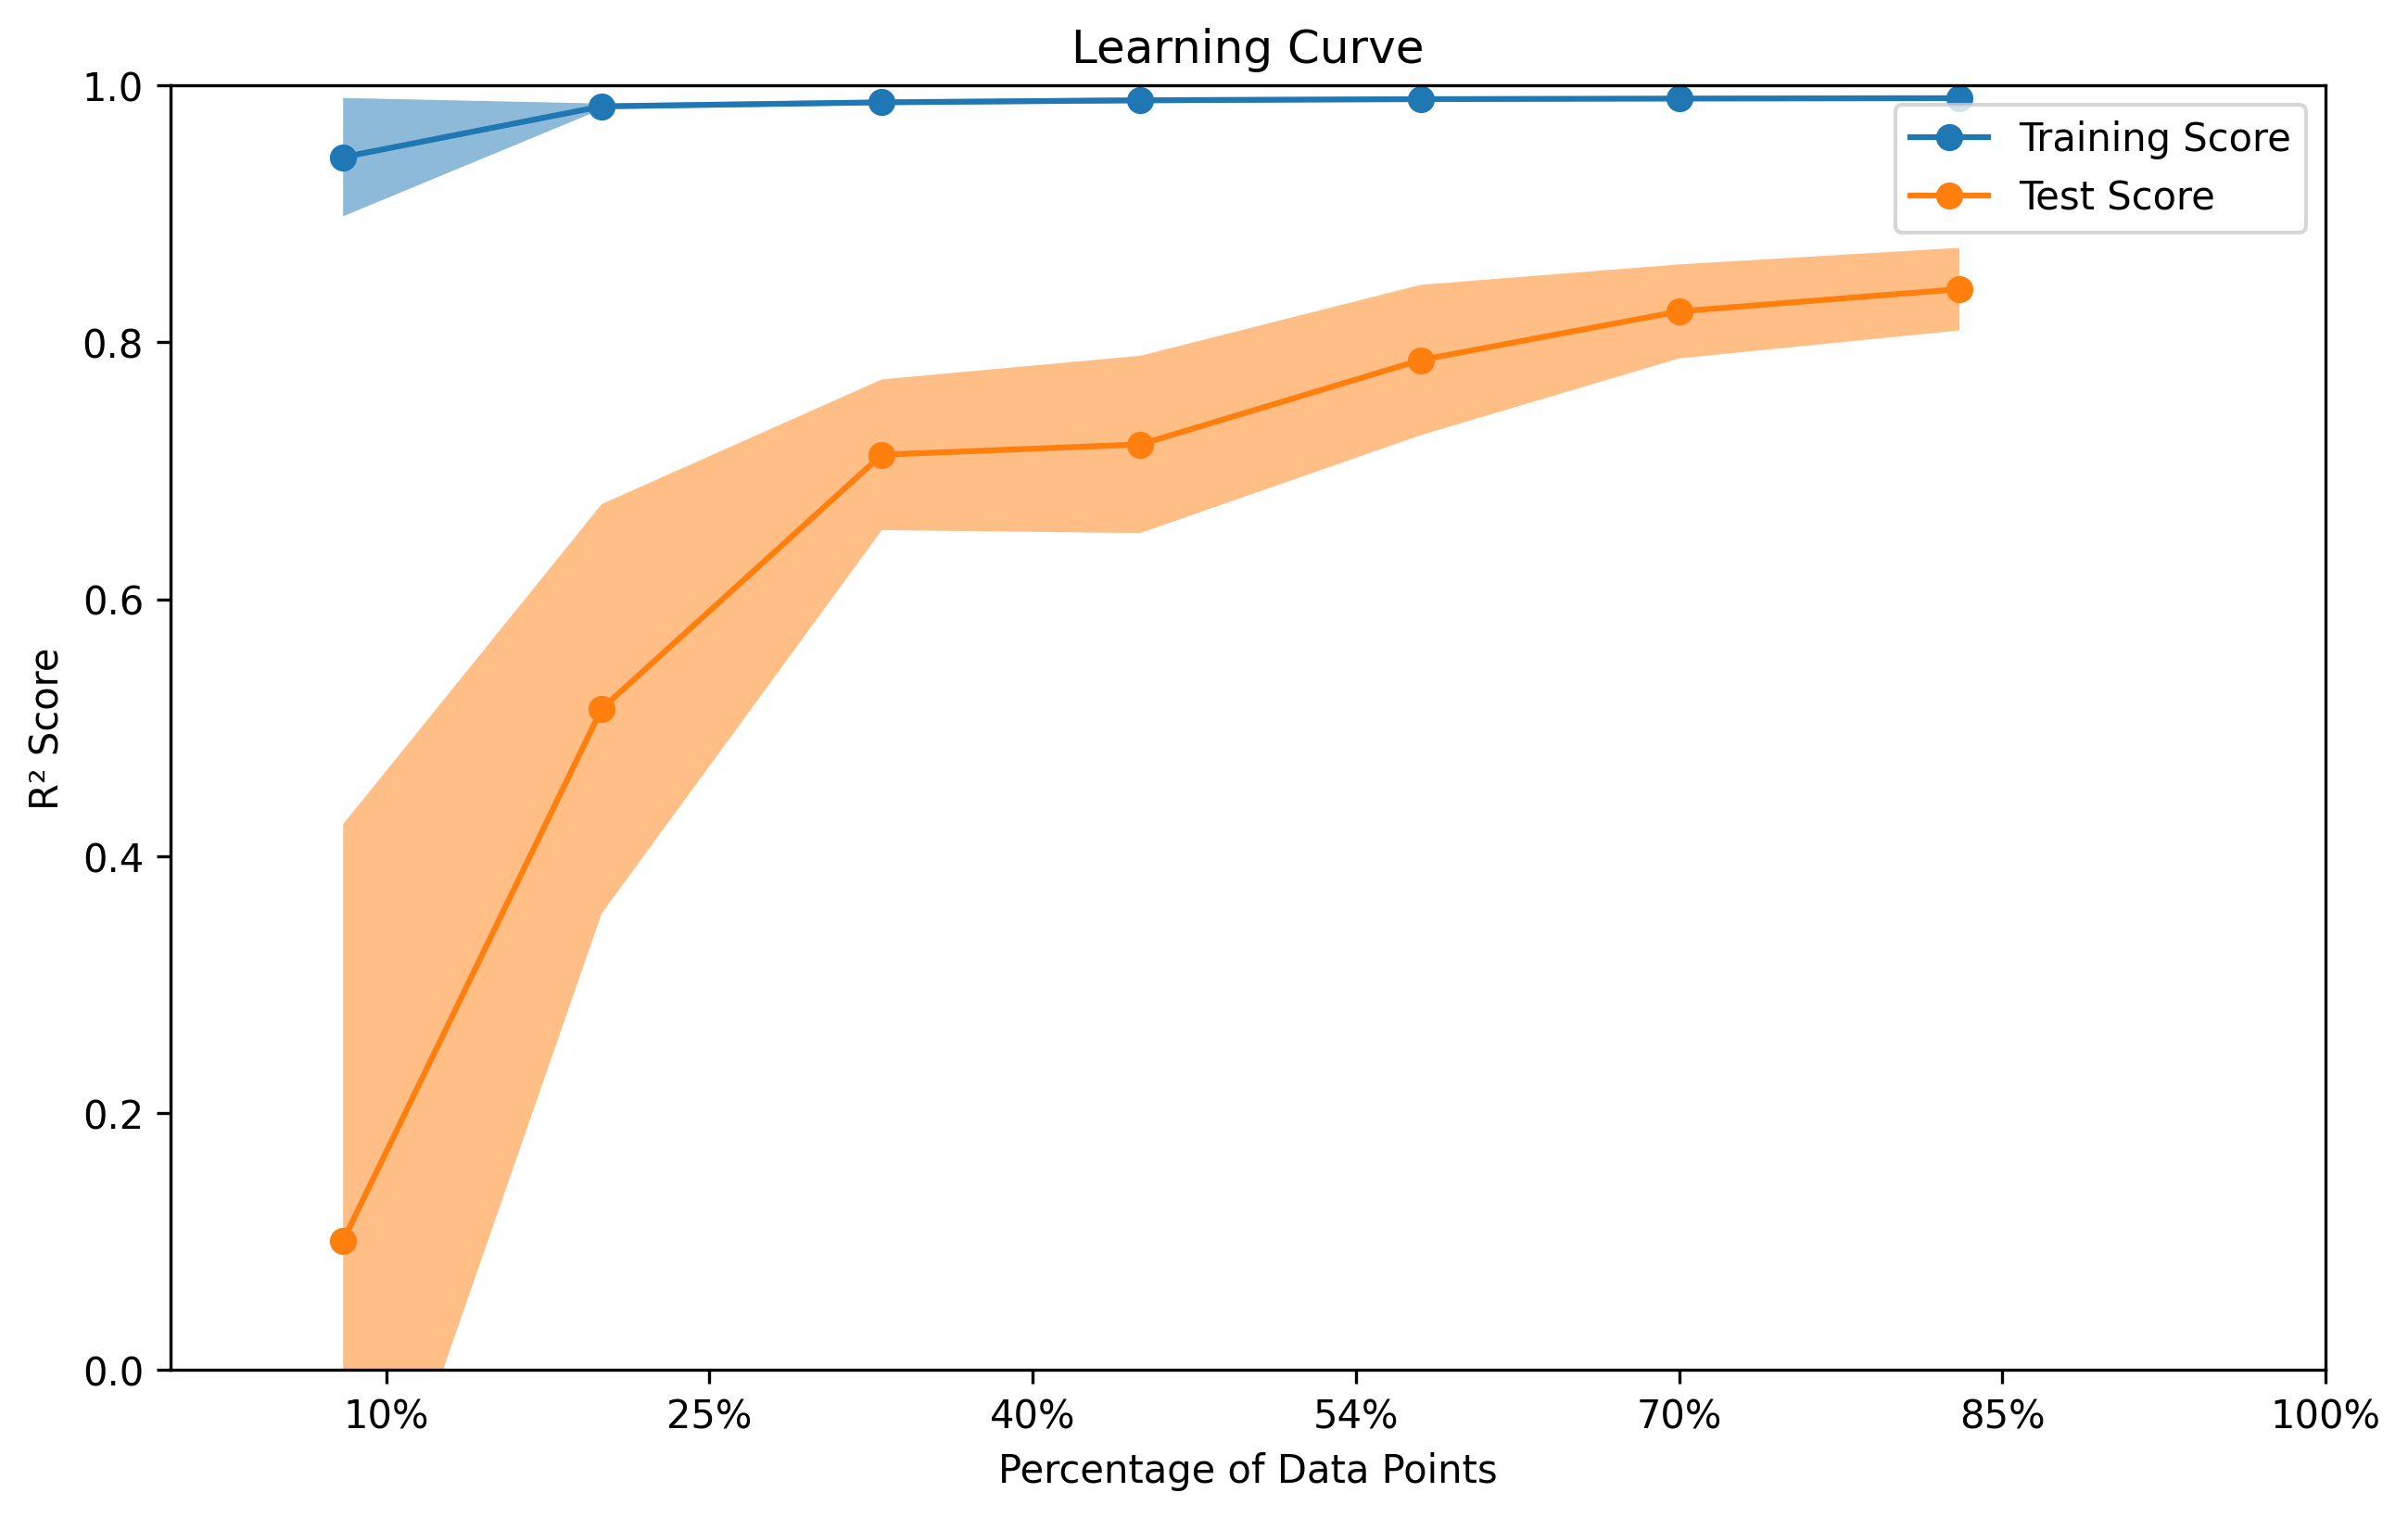

In [10]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 7),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "R2",
}

display = LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)

ax.set_xticks(common_params["train_sizes"] * 100)
ax.set_xticklabels([f"{int(size * 100)}%" for size in common_params["train_sizes"]])
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve")
ax.set_xlabel("Percentage of Data Points")
ax.set_ylabel("R² Score")

# Final model

Text(0.5, 1.0, 'Model performance on test set for all FEs')

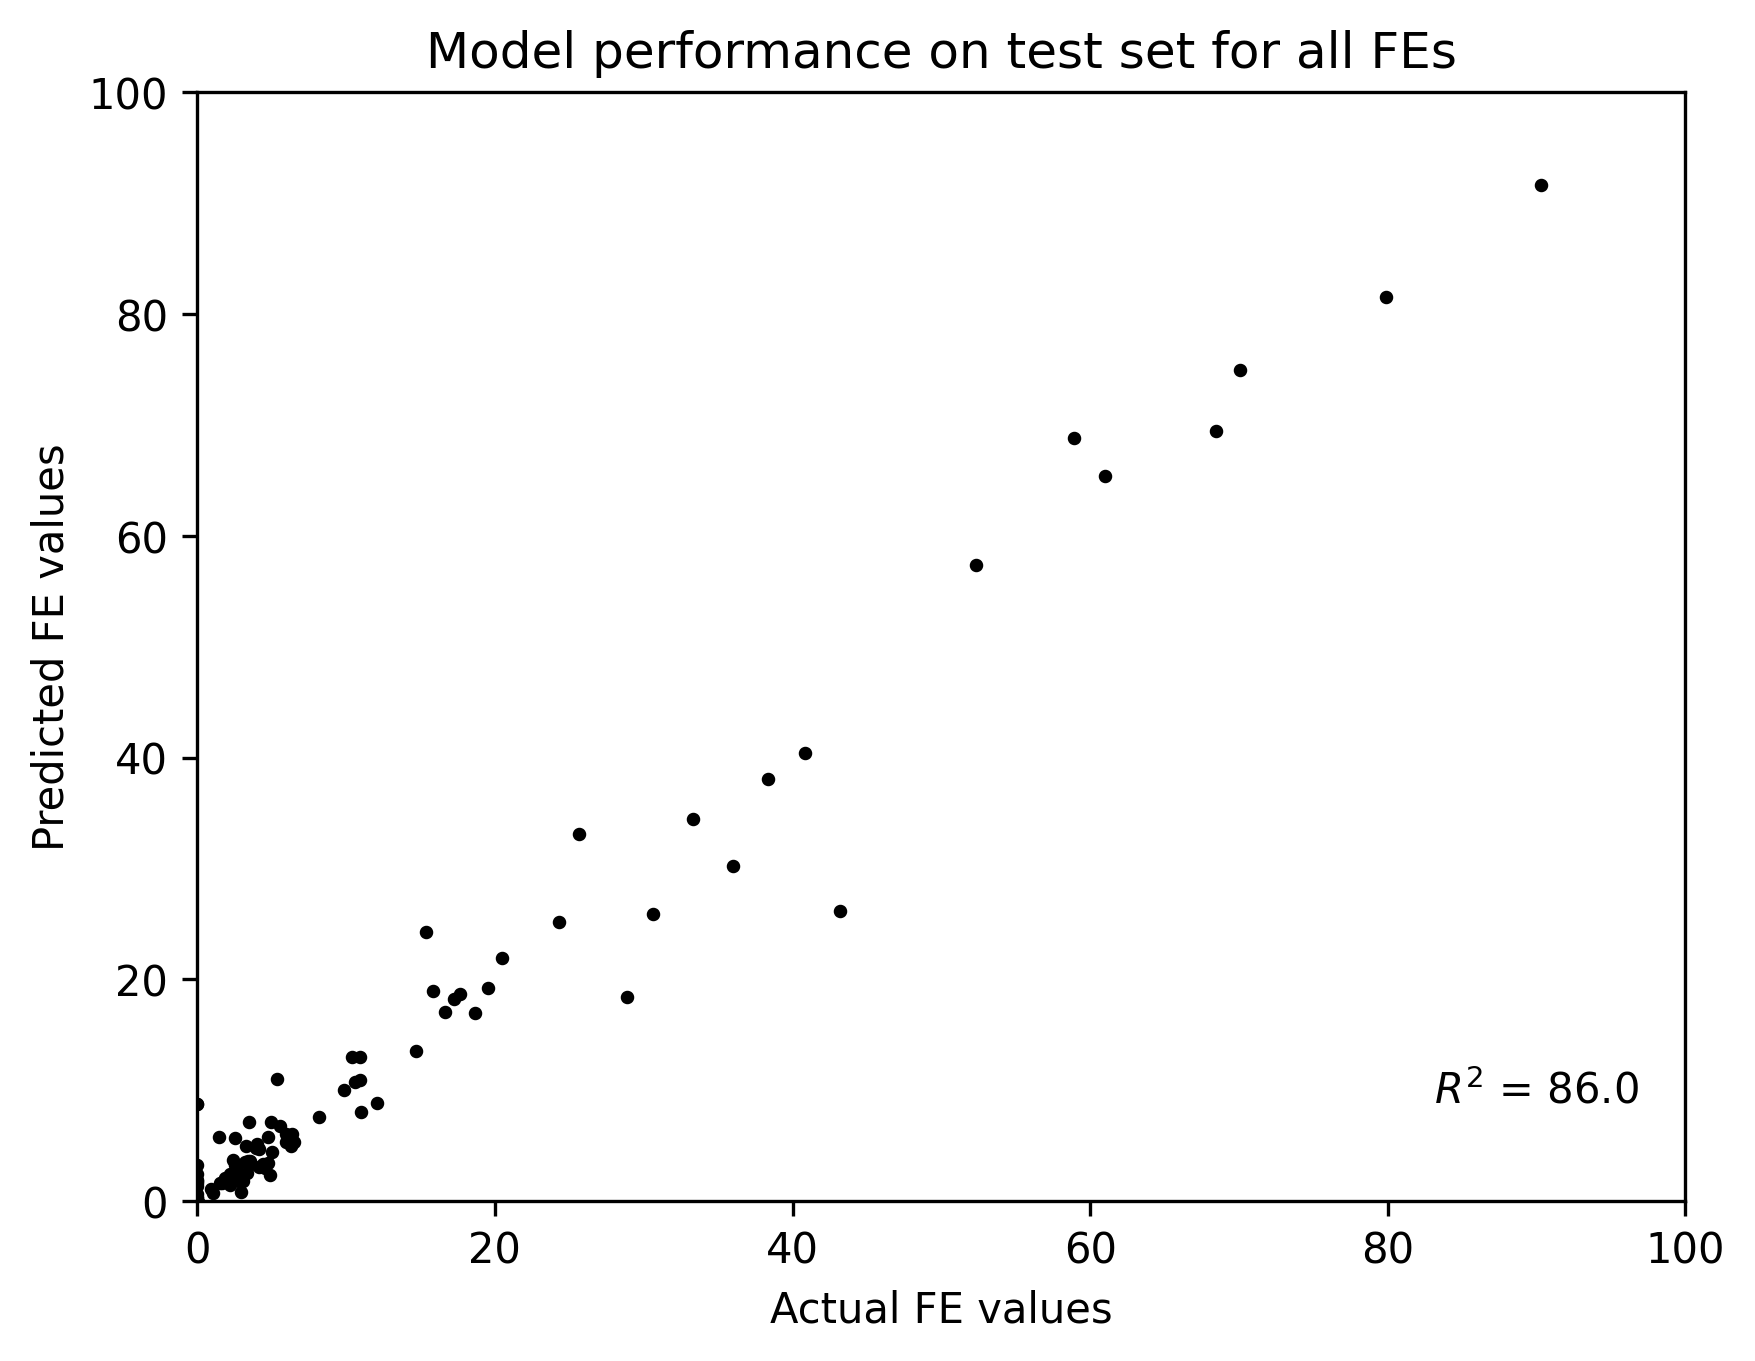

In [45]:
model = MultiOutputRegressor(
    XGBRegressor(
    n_estimators = 250,
    max_depth = 5,
    min_child_weight = 1,
    learning_rate = 0.2,
    subsample = 0.5,
    reg_lambda = 1, 
    reg_alpha = 1,
    gamma = 0,
    colsample_bytree = 0.8,
    n_jobs=1,  # Use a single thread for each model training to avoid oversubscription
    random_state=1
    )
)

seed = 1001

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = r2_score(y_test, y_pred)

plt.scatter(y_test,y_pred, s=5, c = 'k')
plt.xlabel('Actual FE values')
plt.ylabel('Predicted FE values')
ax = plt.gca()
plt.text(0.9, 0.1, r'$R^2$ = ' + str(round(mae*100, 1)), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)

plt.xlim([0,100])
plt.ylim([0,100])
plt.title('Model performance on test set for all FEs')

## Individual plots

In [44]:
targets

['FE(glycerol)',
 'FE(n-proponal)',
 'FE(ethanol)',
 'FE(acetate)',
 'FE(acetone)',
 'FE(formate)']

(0.0, 100.0)

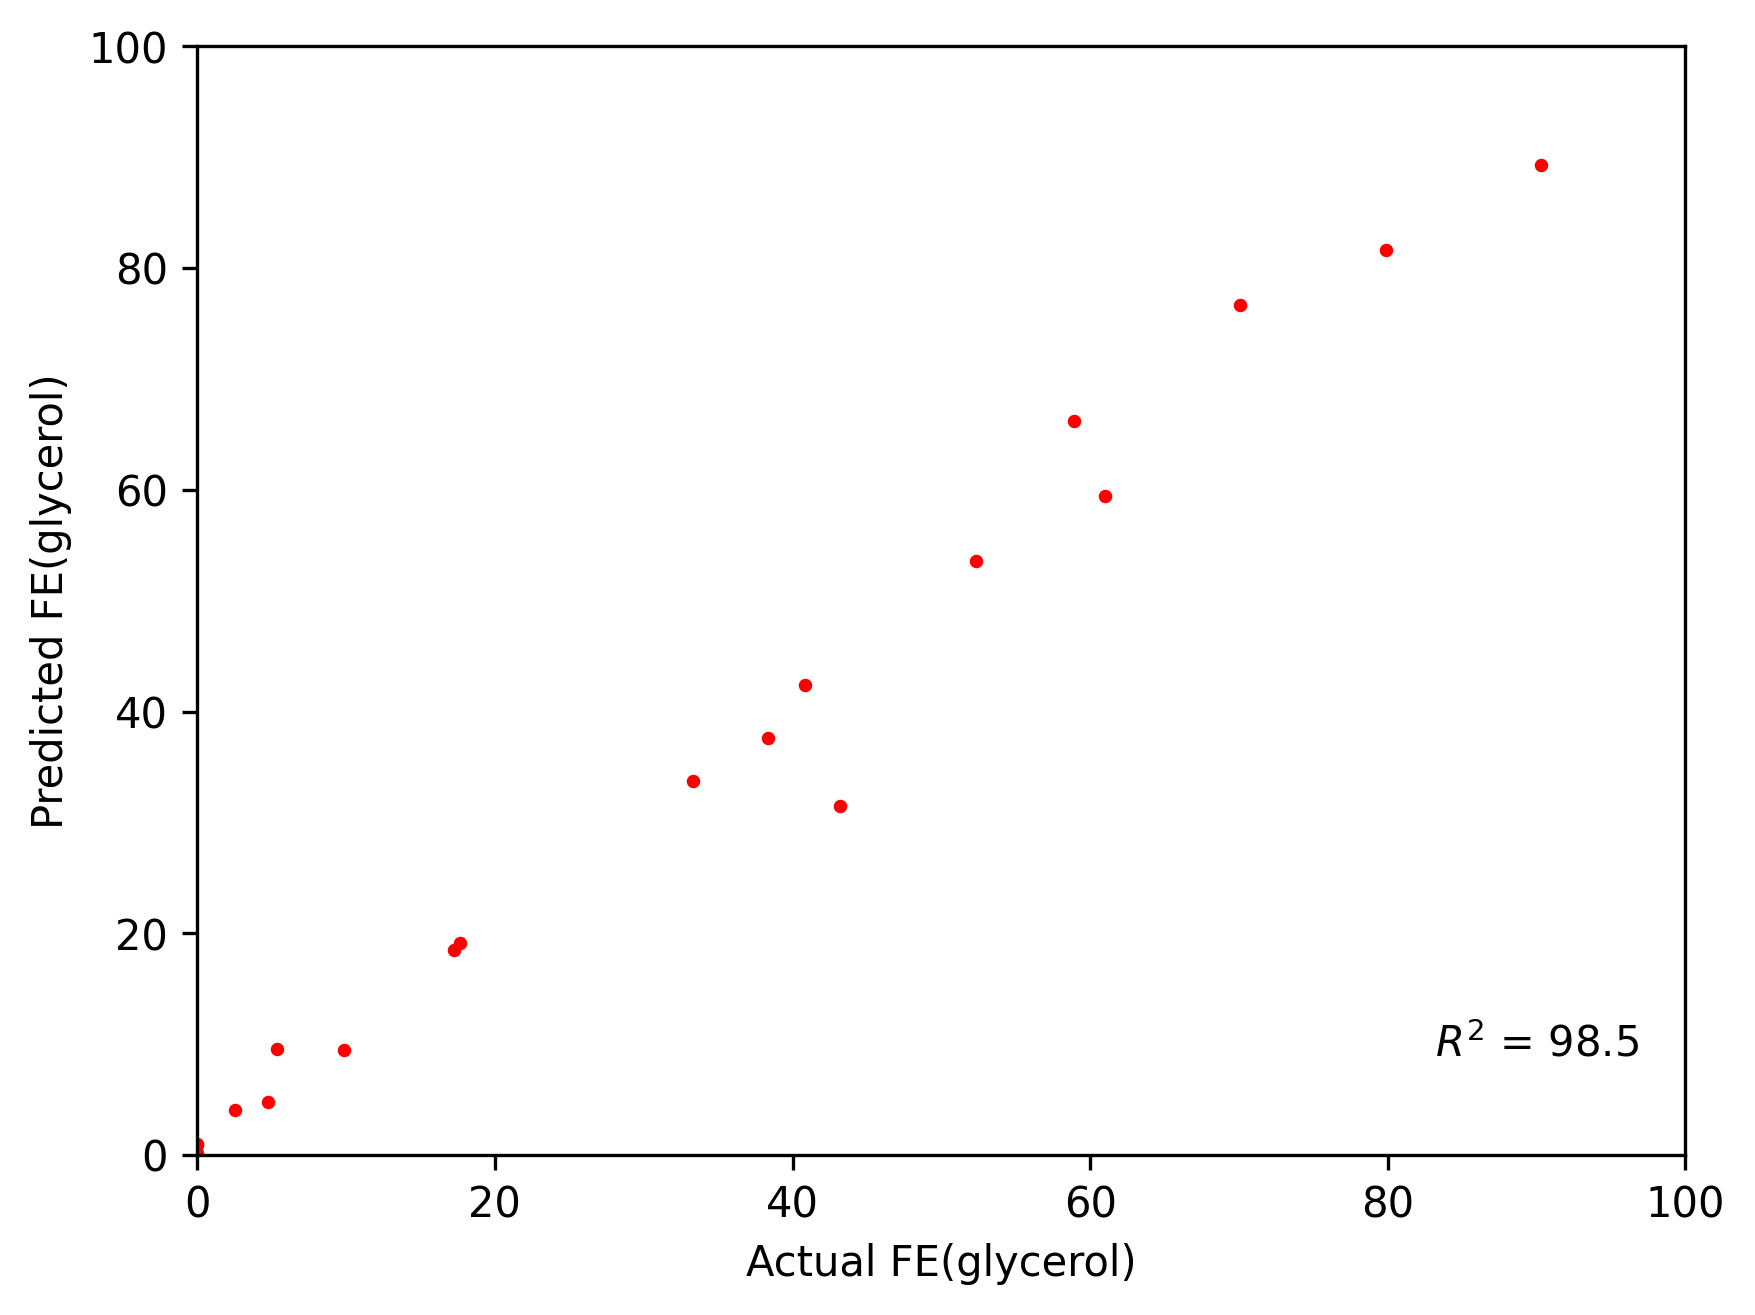

In [54]:
# 'FE(glycerol)'
#y_pred = model.predict(X_test)
actual = y_test['FE(glycerol)']
predicted = y_pred[:,0]
mae = r2_score(actual, predicted)

plt.scatter(actual,predicted, s=5, c = 'red')
plt.xlabel('Actual FE(glycerol)')
plt.ylabel('Predicted FE(glycerol)')
ax = plt.gca()
plt.text(0.9, 0.1, r'$R^2$ = ' + str(round(mae*100, 1)), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)

plt.xlim([0,100])
plt.ylim([0,100])
# plt.title('Model performance on test set for all FEs')

(0.0, 100.0)

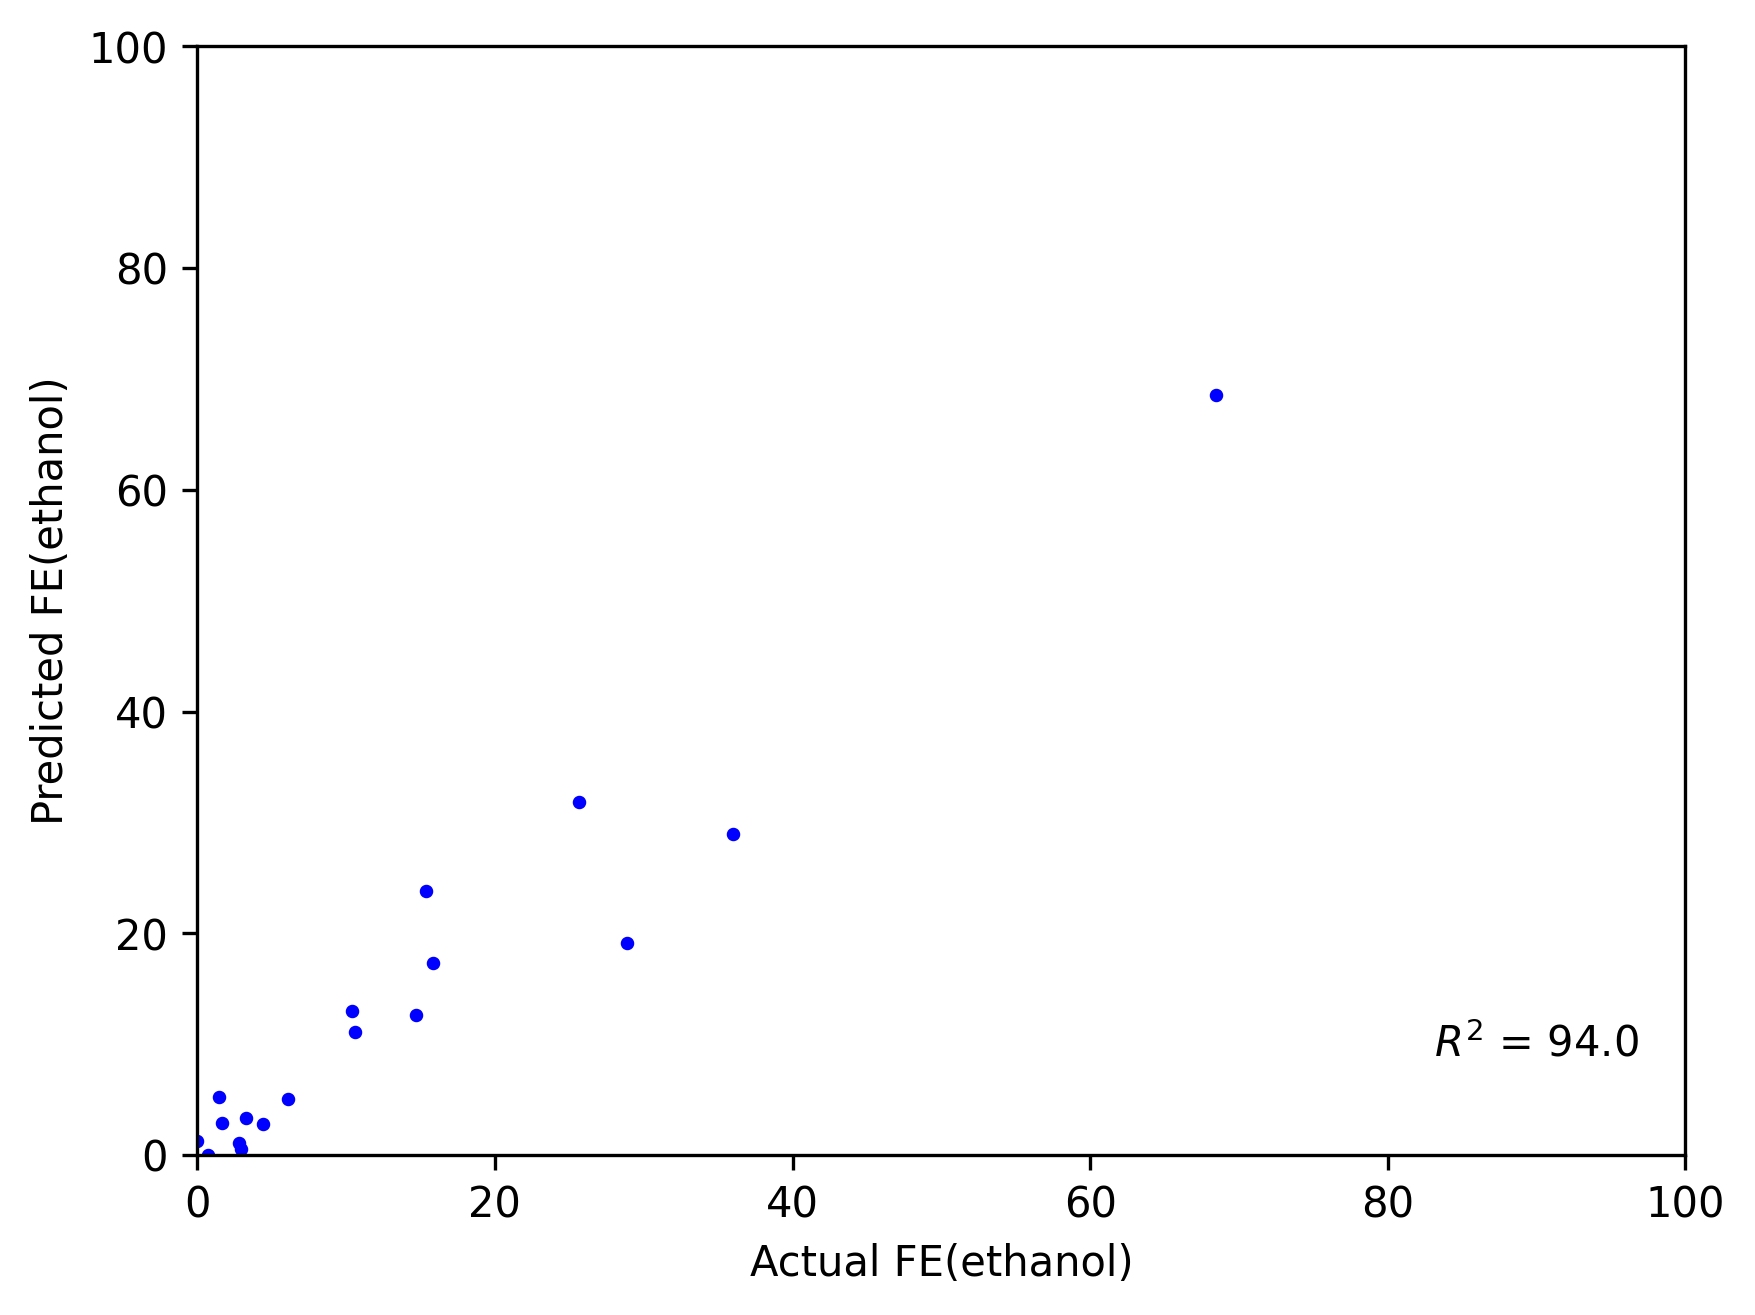

In [57]:
# 'FE(ethanol)'
#y_pred = model.predict(X_test)
actual = y_test['FE(ethanol)']
predicted = y_pred[:,2]
mae = r2_score(actual, predicted)

plt.scatter(actual,predicted, s=5, c = 'blue')
plt.xlabel('Actual FE(ethanol)')
plt.ylabel('Predicted FE(ethanol)')
ax = plt.gca()
plt.text(0.9, 0.1, r'$R^2$ = ' + str(round(mae*100, 1)), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)

plt.xlim([0,100])
plt.ylim([0,100])
# plt.title('Model performance on test set for all FEs')

(0.0, 100.0)

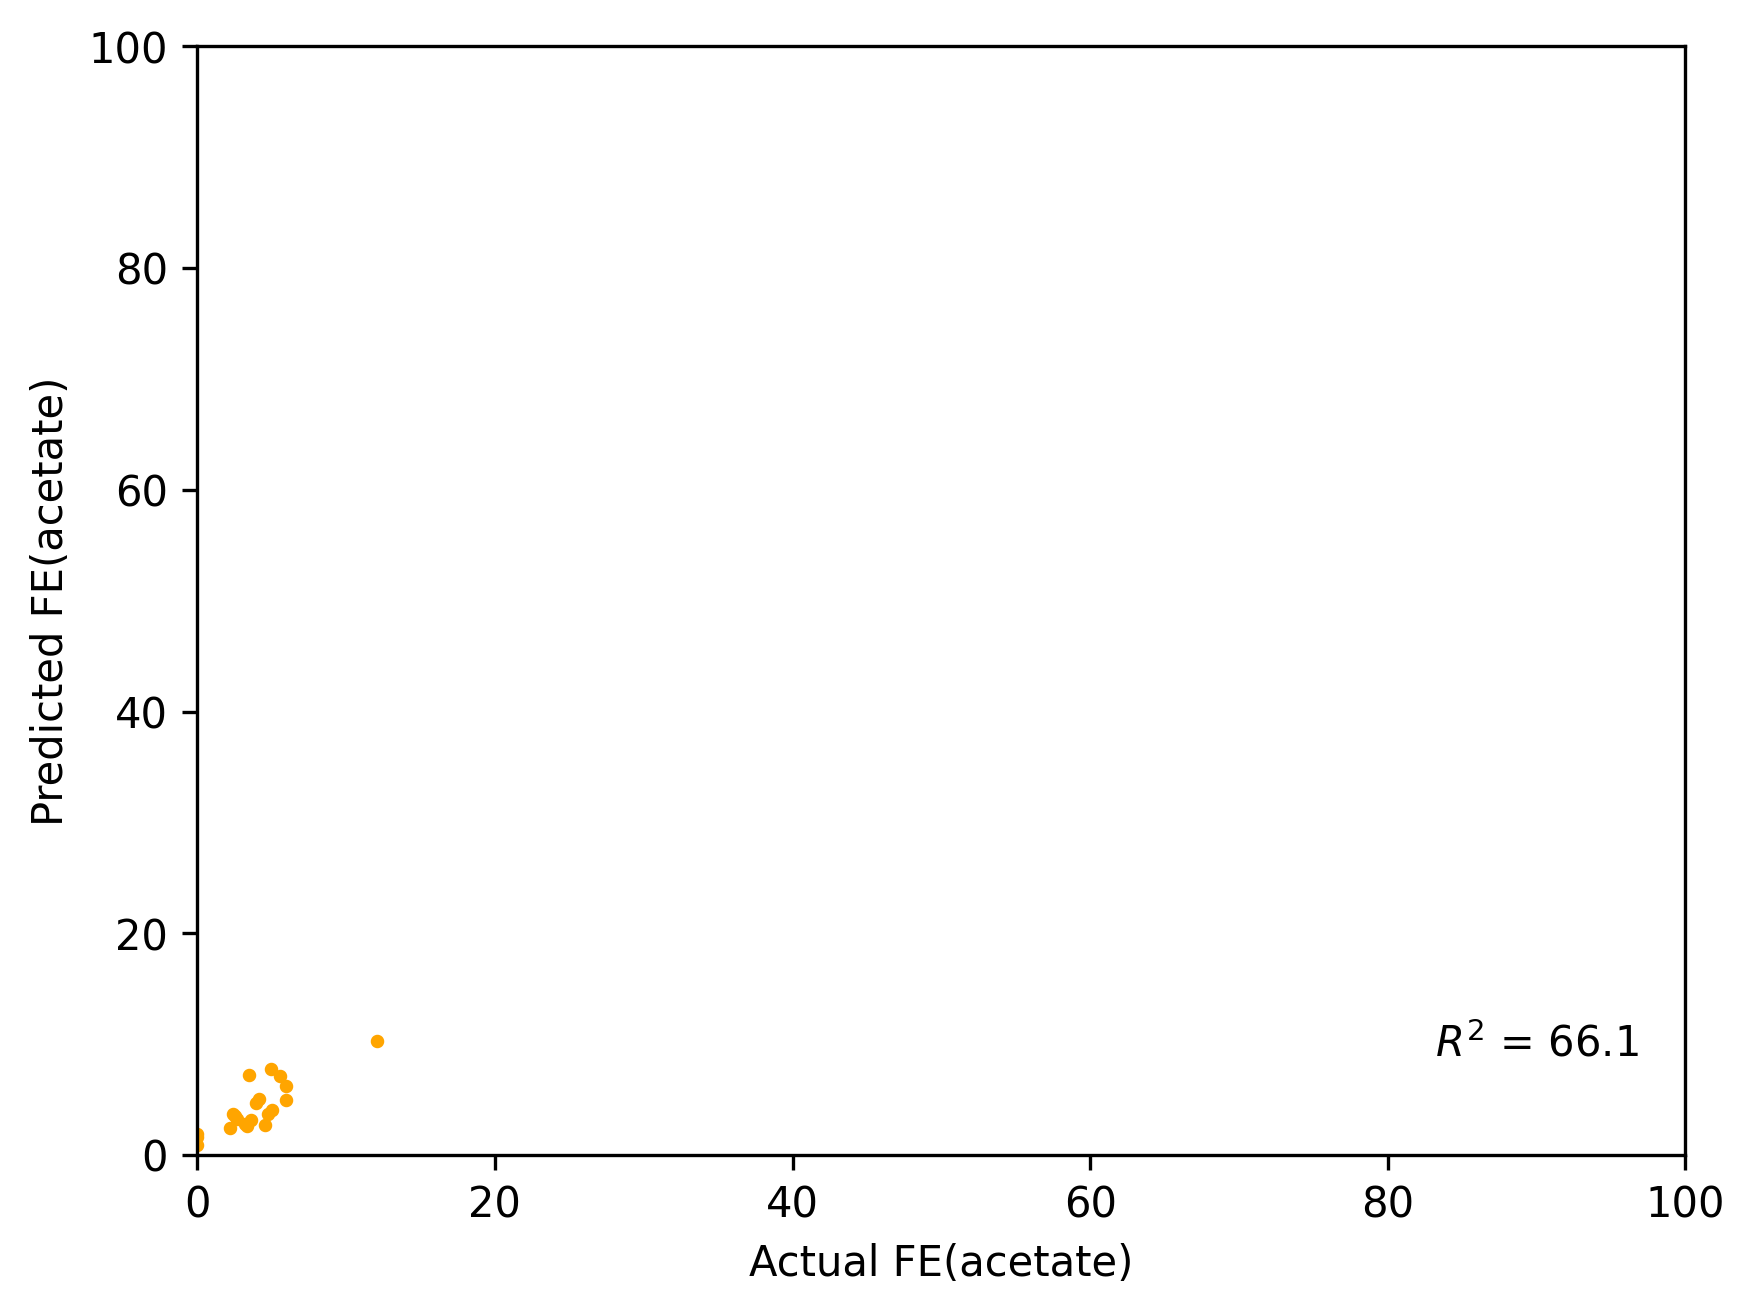

In [58]:
# 'FE(acetate)'
#y_pred = model.predict(X_test)
actual = y_test['FE(acetate)']
predicted = y_pred[:,3]
mae = r2_score(actual, predicted)

plt.scatter(actual,predicted, s=5, c = 'orange')
plt.xlabel('Actual FE(acetate)')
plt.ylabel('Predicted FE(acetate)')
ax = plt.gca()
plt.text(0.9, 0.1, r'$R^2$ = ' + str(round(mae*100, 1)), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)

plt.xlim([0,100])
plt.ylim([0,100])
# plt.title('Model performance on test set for all FEs')

(0.0, 100.0)

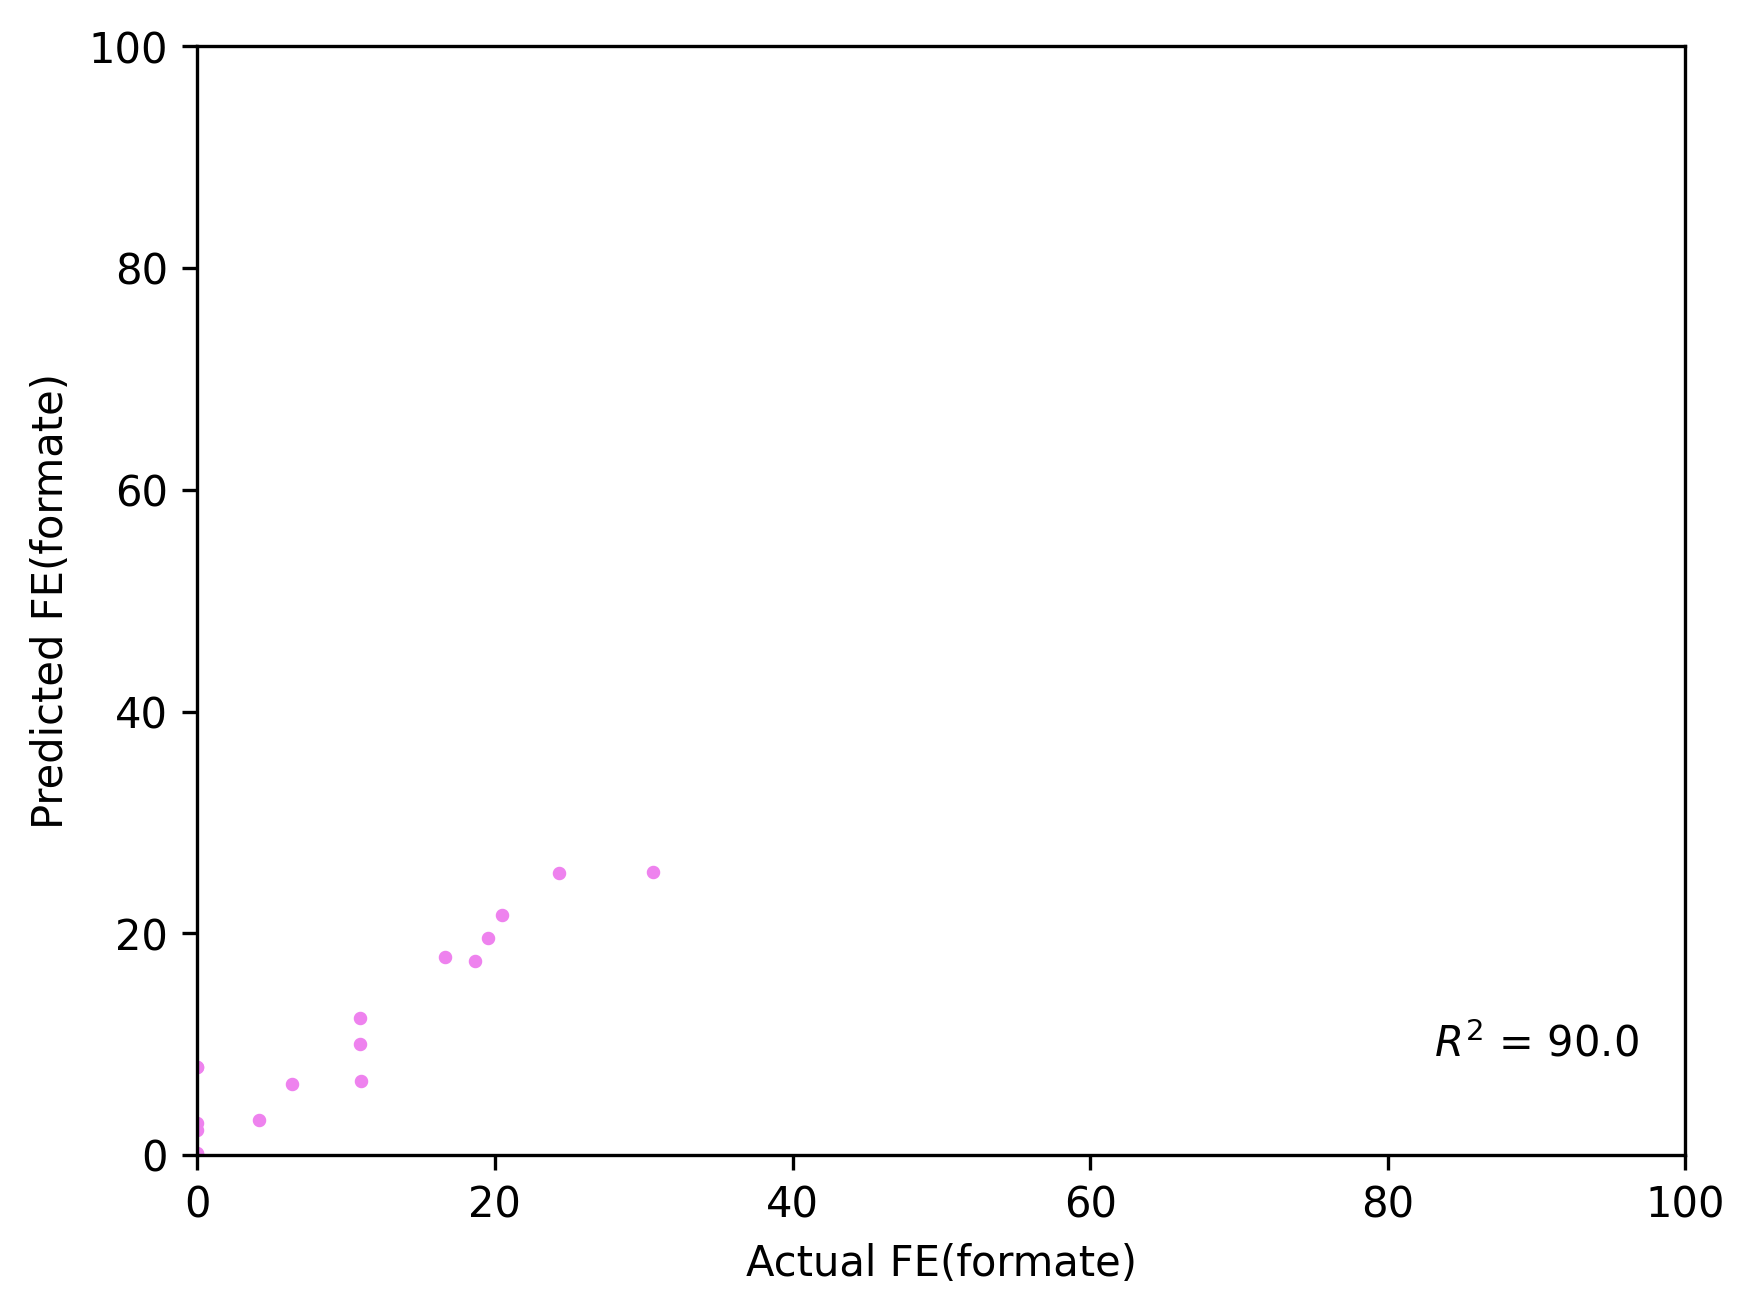

In [59]:
# 'FE(formate)'
#y_pred = model.predict(X_test)
actual = y_test['FE(formate)']
predicted = y_pred[:,-1]
mae = r2_score(actual, predicted)

plt.scatter(actual,predicted, s=5, c = 'violet')
plt.xlabel('Actual FE(formate)')
plt.ylabel('Predicted FE(formate)')
ax = plt.gca()
plt.text(0.9, 0.1, r'$R^2$ = ' + str(round(mae*100, 1)), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)

plt.xlim([0,100])
plt.ylim([0,100])
# plt.title('Model performance on test set for all FEs')